In [97]:
# Library imports.
from pyswmm import Simulation, Links, Output
from swmm.toolkit.shared_enum import LinkAttribute, NodeAttribute
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Local imports.
from urbansurge.file_utils import set_inp_section, add_prcp_timeseries, set_raingage

In [98]:
# Path to the SWMM inp file.
swmm_dir = Path(r"C:\Users\ay434\Box\Research\NSF_SCC\SWMM\SWMM_Files\SWMM")
inp_name = "Canandaigua - Copy.inp"
out_name = "Canandaigua - Copy.out"

swmm_path = str(swmm_dir / inp_name)
swmm_out_path = str(swmm_dir / out_name)

In [99]:
def unpack_series(series):
    "Unpacks SWMM output series into datetime and values."
    dts = [key for key in series.keys()]
    values = [val for val in series.values()]
    
    return dts, values

In [110]:
# Diameter values for a given component.
diameter_vals = [4.5, 4.6, 4.7, 4.8, 4.9, 5]
# diameter_vals = np.linspace(2.5, 3.5, 25)

# Data from outfall.
outfall_data = {}

# Loop through roughness values and run model. Collect output flow at outfall.
for i, rough_val in enumerate(diameter_vals):

    # SWMM simulation.
    with Simulation(swmm_path) as sim:
        # Edit link parameters.
#         # -----------------------------------
#         section = 'CONDUITS'

#         # Edit 1.
#         column_name = 'Roughness'
#         component_name = 3
#         new_value = rough_val
#         set_inp_section(swmm_path, section, column_name, component_name, new_value)

        # -----------------------------------
        
        # Diameter editing.
        # ----------------------------------------
        component_name = 2
        diam_section = 'XSECTIONS'
        column_name = 'Geom1'
        new_diam = rough_val

        # Set the new diameter.
        set_inp_section(swmm_path, diam_section, column_name, component_name, new_diam)

        # Edit precipitation timeseries.
        # -----------------------------------    
        # Edit 1.
        ts_name = '1in-6hr'
#         ts_description = 'TS_TEST_DESC'
#         times = [0, 1, 2, 3, 4, 5, 6]
#         values = [0, 0.1667, 0.1333, 0.1, 0.0666, 0.0333, 0.0]
# #         values = [0, 0.333, 0.2666, 0.2, 0.1333, 0.0666, 0.0]
#         add_prcp_timeseries(swmm_path, ts_name, ts_description, times, values, overwrite=True)

        # Set new timeseries to rain gauge.
        section = 'RAINGAGES'
        rg_ts_name = f'TIMESERIES {ts_name}'
        component_name = 1
        column_name = 'Source'
        set_raingage(swmm_path, column_name, component_name, rg_ts_name)

    # -----------------------------------
    with Simulation(swmm_path) as sim:
        # Run the model.
        for ind, step in enumerate(sim):
            if ind % 100 == 0:
                print(sim.current_time, ",", round(sim.percent_complete * 100))
                
    # Collect output.
    # -----------------------------------
    with Output(swmm_out_path) as out:
        node_dt, node_series = unpack_series(out.node_series('18', NodeAttribute.INVERT_DEPTH))

    outfall_data[f'outfall_depth_{rough_val}'] = node_series
    outfall_data['datetime'] = node_dt


Updated Geom1 value to 4.5 for 2 in 2
2017-01-01 00:00:30 , 0
2017-01-01 00:50:30 , 4
2017-01-01 01:40:30 , 7
2017-01-01 02:30:30 , 10
2017-01-01 03:20:30 , 14
2017-01-01 04:10:30 , 17
2017-01-01 05:00:30 , 21
2017-01-01 05:50:30 , 24
2017-01-01 06:40:30 , 28
2017-01-01 07:30:30 , 31
2017-01-01 08:20:30 , 35
2017-01-01 09:10:30 , 38
2017-01-01 10:00:30 , 42
2017-01-01 10:50:30 , 45
2017-01-01 11:40:30 , 49
2017-01-01 12:30:30 , 52
2017-01-01 13:20:30 , 56
2017-01-01 14:10:30 , 59
2017-01-01 15:00:30 , 63
2017-01-01 15:50:30 , 66
2017-01-01 16:40:30 , 69
2017-01-01 17:30:30 , 73
2017-01-01 18:20:30 , 76
2017-01-01 19:10:30 , 80
2017-01-01 20:00:30 , 83
2017-01-01 20:50:30 , 87
2017-01-01 21:40:30 , 90
2017-01-01 22:30:30 , 94
2017-01-01 23:20:30 , 97
Updated Geom1 value to 4.6 for 2 in 2
2017-01-01 00:00:30 , 0
2017-01-01 00:50:30 , 4
2017-01-01 01:40:30 , 7
2017-01-01 02:30:30 , 10
2017-01-01 03:20:30 , 14
2017-01-01 04:10:30 , 17
2017-01-01 05:00:30 , 21
2017-01-01 05:50:30 , 24
2017-

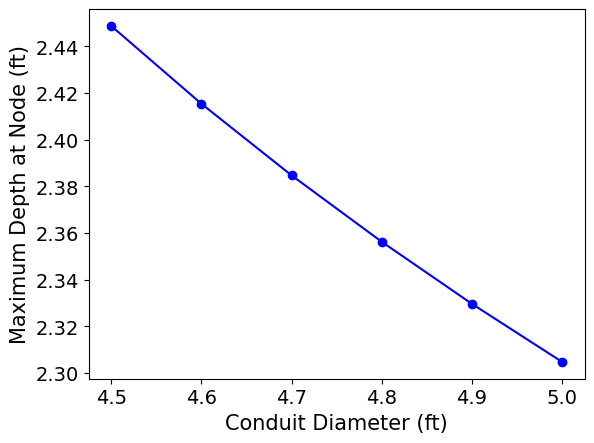

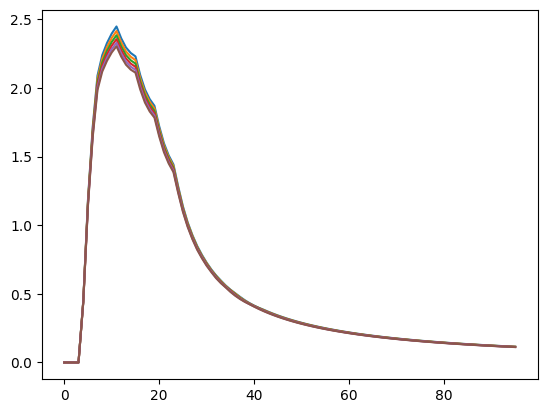

In [118]:
# Make a data frame from the output data.
outfall_df = pd.DataFrame(outfall_data)

outfall_cols = []
for col in outfall_df.columns:
    if 'outfall' in col:
        outfall_cols.append(col)

max_depths = outfall_df.loc[:, outfall_cols].max()

fig, ax = plt.subplots()
ax.plot(diameter_vals, max_depths, 'bo-')
ax.set_xlabel('Conduit Diameter (ft)', fontsize=15)
ax.set_ylabel('Maximum Depth at Node (ft)', fontsize=15)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.show()

fig, ax = plt.subplots()
for col in outfall_df.columns:
    if 'outfall' in col:
        ax.plot(outfall_df.loc[:, col])